#  Real estate prices prediction
## by:
<p><strong>Mashari Almuhanna</strong></p>
         <b>Sohaib Albakri</b>


## Problem

> Most of the preparty owners those trying to set a selling price for their property does not
know what is the best price which make them set a high price or to low. 

## Solution

>In this project, we will develop a linear regression model to predict the property prices
according to its characteristics and location. Which will help the owners to set the best price.

## Dataset 
> The dataset we will use contains the number of rooms, number of baths the size of the property,
price, and the district. The data are taken from the [Aqar website](https://sa.aqar.fm/%D8%A8%D9%8A%D8%AA-%D9%84%D9%84%D8%A8%D9%8A%D8%B9/%D8%A7%D9%84%D8%B1%D9%8A%D8%A7%D8%B6). The following table explains the
dataset in detail:

- Rooms | Number of the bedrooms (Integer)<br>

- Baths | Number of the bathrooms(Integer)
- Size  | Size of the house in squared meter (Integer)
- Price | Price of the house on Saudi Riyals(Integer)
- District | the District the house on (String)


In [1]:
from bs4 import BeautifulSoup
import requests
import math
import pandas as pd
import patsy

import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures,StandardScaler
from sklearn.pipeline import make_pipeline

import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()



## Web Scraping 

In [2]:
url = 'https://ar.wikipedia.org/wiki/%D8%A3%D8%AD%D9%8A%D8%A7%D8%A1_%D8%A7%D9%84%D8%B1%D9%8A%D8%A7%D8%B6' 
response = requests.get(url)
response.status_code
page = response.text
soup = BeautifulSoup(page, "lxml")

In [3]:
districts = ["طويق", "الحائر", "الاندلس", "الشرفية", "الشفا", "البيان", "الصالحية", "غبيرة", "العيينة", "ام سليم", "الشرق"]
table = soup.find(class_="wikitable")
rows = soup.find_all("tr")
dist = []
for r in rows:
    tds = r.find_all("td")
    if len(tds) >= 2:
        districts.append(tds[1].text)

In [4]:
fixed_districts = []
for d in districts:
    fixed = d.replace("حي ", "")
    fixed = fixed.replace("الغربي ", "")
    fixed = fixed.replace("الشرقي ", "")
    fixed = fixed.replace("الغربية ", "")
    fixed = fixed.replace("الشرقية ", "")
    fixed = fixed.replace("الشرقية ", "")
    fixed = fixed.replace("الشرقية ", "")
    fixed = fixed.replace("\n", "")
    
    if(len(fixed) > 1):
        valid = True
        for character in fixed:
            if character.isdigit():
                valid = False
                break

        if valid:
            fixed_districts.append(fixed)

In [5]:
print(list(set(fixed_districts)))

In [6]:
def prepare_data(houses_list, soup, districts):
    houses=soup.find_all(class_='titleAndDetails')
    headers = ["PRICE", "BED", "BATH", "SIZE", "DISTRICT"]

    for house in houses:
        price = int(house.find(class_="price").text.replace("ريال", "").replace(",", "").strip())
        bed = int(house.find(class_="bed").text.strip())
        bath = int(house.find(class_="bath").text.strip())
        size = int(house.find(class_="size").text.replace("م²", "").strip())
        address = house.find(class_="listTitle").text.strip()

        house_dist = None
        for district in districts:
            if district in address:
                house_dist = district.strip()
                break
            
        house_dict = dict(zip(headers, [price, bed, bath, size, house_dist]))
        houses_list.append(house_dict)

In [7]:
houses_list = []
i = 1
while i < 50:
    url = f'https://sa.aqar.fm/%D8%A8%D9%8A%D8%AA-%D9%84%D9%84%D8%A8%D9%8A%D8%B9/%D8%A7%D9%84%D8%B1%D9%8A%D8%A7%D8%B6/{i}' 
    response = requests.get(url)
    if response.status_code == 200:
        page = response.text
        soup = BeautifulSoup(page, "lxml")
        prepare_data(houses_list, soup, fixed_districts)
        i += 1
    else:
        break

In [8]:
df = pd.DataFrame(houses_list)
df

In [9]:
df = pd.read_csv('Aqar.csv')
df.head()

,Unnamed: 0,PRICE,BED,BATH,SIZE,DISTRICT
0,0,3000000,5,4,1100,الخليج
1,1,4930000,5,4,1030,الرمال
2,2,780000,5,4,455,الدار البيضاء
3,3,880000,5,4,375,النسيم الغربي
4,4,1800000,5,5,800,طويق


In [49]:
df.describe()

,Unnamed: 0,PRICE,BED,BATH,SIZE
count,958.000000,9.580000e+02,958.000000,958.000000,958.000000
mean,483.768267,1.059222e+06,4.455115,3.525052,392.212944
std,278.810832,1.103600e+06,0.947730,1.146937,347.598518
min,0.000000,1.000000e+04,1.000000,1.000000,50.000000
25%,242.500000,2.500000e+05,4.000000,3.000000,150.250000
50%,485.500000,8.000000e+05,5.000000,4.000000,350.000000
75%,724.750000,1.300000e+06,5.000000,4.000000,450.000000
max,964.000000,7.000000e+06,5.000000,5.000000,4900.000000


## Feature Engineering 

In [10]:
dfe = df.copy()

In [11]:
dfe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 965 entries, 0 to 964
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  965 non-null    int64 
 1   PRICE       965 non-null    int64 
 2   BED         965 non-null    int64 
 3   BATH        965 non-null    int64 
 4   SIZE        965 non-null    int64 
 5   DISTRICT    958 non-null    object
dtypes: int64(5), object(1)
memory usage: 45.4+ KB


In [12]:
dfe.dropna(inplace=True)

In [13]:
dfe.drop(['Unnamed: 0'], axis = 1, inplace = True)

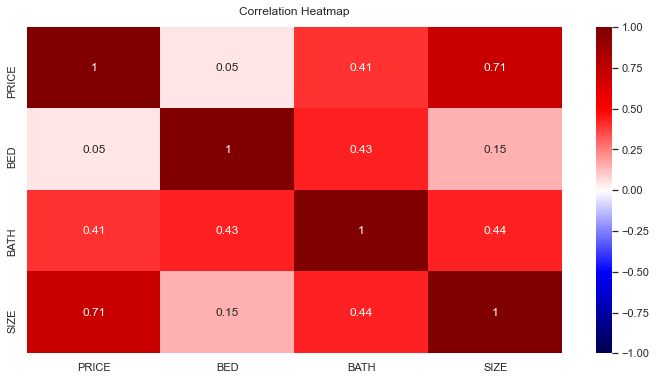

In [14]:
# Checking features correlation
plt.figure(figsize=(12, 6))
heatmap = sns.heatmap(dfe.corr(), vmin=-1, vmax=1, annot=True,cmap='seismic')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);
plt.show() 

From the Graph we noticed the relations between columns

In [15]:
dfe.head()

,PRICE,BED,BATH,SIZE,DISTRICT
0,3000000,5,4,1100,الخليج
1,4930000,5,4,1030,الرمال
2,780000,5,4,455,الدار البيضاء
3,880000,5,4,375,النسيم الغربي
4,1800000,5,5,800,طويق


In [16]:
# split into train and target
X,y = dfe.iloc[:,1:],dfe['PRICE']

In [17]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 958 entries, 0 to 964
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   BED       958 non-null    int64 
 1   BATH      958 non-null    int64 
 2   SIZE      958 non-null    int64 
 3   DISTRICT  958 non-null    object
dtypes: int64(3), object(1)
memory usage: 37.4+ KB


In [18]:
nbh_counts = dfe.DISTRICT.value_counts()
(nbh_counts >5).value_counts()

False    46
True     35
Name: DISTRICT, dtype: int64

In [19]:
other_nbhs = list(nbh_counts[nbh_counts <= 5].index)

dfe['DISTRICT']= dfe['DISTRICT'].replace(other_nbhs, 'اخرى')
dfe.DISTRICT.value_counts()

منفوحة           106
اخرى              89
طويق              88
الندوة            57
الرمال            39
النسيم الغربي     37
السعادة           34
الخالدية          32
الخليج            32
الصالحية          27
البديعة           26
اليمامة           26
الدار البيضاء     26
عتيقة             25
غبيرة             23
العزيزية          21
الملز             20
ظهرة لبن          19
بدر               19
العريجاء          18
الفيحاء           17
الاندلس           16
المروة            15
العيينة           15
النظيم            15
الفوطة            15
أحد               14
الديرة            13
الجرادية          13
الشميسي           13
الحائر            10
ام سليم            8
المرقب             8
الشرق              8
السويدي            7
ديراب              7
Name: DISTRICT, dtype: int64

In [20]:
dfe = pd.get_dummies(dfe, columns = ['DISTRICT'])
dfe.drop(['DISTRICT_الحائر'], axis = 1, inplace = True)
dfe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 958 entries, 0 to 964
Data columns (total 39 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   PRICE                   958 non-null    int64
 1   BED                     958 non-null    int64
 2   BATH                    958 non-null    int64
 3   SIZE                    958 non-null    int64
 4   DISTRICT_أحد            958 non-null    uint8
 5   DISTRICT_اخرى           958 non-null    uint8
 6   DISTRICT_الاندلس        958 non-null    uint8
 7   DISTRICT_البديعة        958 non-null    uint8
 8   DISTRICT_الجرادية       958 non-null    uint8
 9   DISTRICT_الخالدية       958 non-null    uint8
 10  DISTRICT_الخليج         958 non-null    uint8
 11  DISTRICT_الدار البيضاء  958 non-null    uint8
 12  DISTRICT_الديرة         958 non-null    uint8
 13  DISTRICT_الرمال         958 non-null    uint8
 14  DISTRICT_السعادة        958 non-null    uint8
 15  DISTRICT_السويدي       

## Modeling

In [21]:
X,y = dfe.iloc[:,1:],dfe['PRICE']

In [22]:
model = LinearRegression()

In [23]:
def split_and_validate(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''

     # perform train/val split
    X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.20, random_state=24) # "= \ to coinsder this line with the above one"
    
    # fit linear regression to training data
    lr_model = LinearRegression() 
    lr_model.fit(X_train, y_train)
    model=lr_model
    
    # fit Ridge regression 
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_test_scaled = scaler.transform(X_test)

    lm_reg = Ridge(alpha=2)
    lm_reg.fit(X_scaled,y)


    
    # score fit model on validation data
    val_score_linear = cross_val_score(lr_model, X, y, cv = 5).mean()
    val_score_rid = cross_val_score(lm_reg, X, y, cv = 5).mean()
    
    # report results

    print(f'Linear Regression test R^2: {lr_model.score(X_test, y_test):.3f}')
    print('\nCross Validation for Linear model score was:', val_score_linear)
#     X_poly_test = poly_reg.fit_transform(X_test)
    print(f'\nRidge Regression test R^2: {lm_reg.score(X_test_scaled, y_test):.3f}')
#     print(X_poly_test)
    print('\nCross Validation for Ridge model was score was:', val_score_rid)
#     print('Feature coefficient results: \n')
#     for feature, coef in zip(X.columns, lr_model.coef_):
#         print(feature, ':', f'{coef:.2f}') # "means 2 decimal points"

In [24]:
split_and_validate(X,y)

Linear Regression test R^2: 0.793

Cross Validation for Linear model score was: 0.7678021535973024

Ridge Regression test R^2: 0.820

Cross Validation for Ridge model was score was: 0.7575188216753838


In [25]:
X2 = X.copy()

X2['BED2'] = X2['BED'] ** 2 # "adding quadratic terms to the data frame"
X2['BATH2'] = X2['BATH'] ** 2

In [26]:
split_and_validate(X2,y)

Linear Regression test R^2: 0.793

Cross Validation for Linear model score was: 0.7681041466165472

Ridge Regression test R^2: 0.820

Cross Validation for Ridge model was score was: 0.7557770192018748


In [27]:
X3 = X2.copy()

# division interaction
X3['SIZE/BED'] = X3['SIZE'] / X3['BED']

In [28]:
split_and_validate(X3,y)

Linear Regression test R^2: 0.792

Cross Validation for Linear model score was: 0.7594178830235617

Ridge Regression test R^2: 0.819

Cross Validation for Ridge model was score was: 0.7511821156639161


In [29]:
df.dropna(inplace=True)
X4 =df.iloc[:,2:5]
split_and_validate(X4,y)

Linear Regression test R^2: 0.692

Cross Validation for Linear model score was: 0.5124000100581959

Ridge Regression test R^2: 0.715

Cross Validation for Ridge model was score was: 0.5123955133455894


In [30]:
X5 = X2.copy()

X5['SIZE2'] = X2['SIZE'] ** 2 # "adding quadratic terms to the data frame"

In [31]:
split_and_validate(X5,y)

Linear Regression test R^2: 0.833

Cross Validation for Linear model score was: 0.8103161794208258

Ridge Regression test R^2: 0.842

Cross Validation for Ridge model was score was: 0.8175526160253886


> 1- So we found out at `X2` is the same score for both models.<br>

> 2- `X3` the score was less by 0.01 for both models.<br>

> 3- In `X4` the score was less by 0.20 for both models and CV score just 0.51 so it is the worst model of them.<br>

> 4- But at `X5` we has increasd the score of the model from 0.73 to 0.833 and cv from 0.76 to 0.81 for linear and for Ridge Regression scored 0.842 and CV 0.818 so it is the best model we can achieve 

## Assumptions

### Assumption 1: regression is linear in parameters and correctly specified

In [32]:
def diagnostic_plot(x, y):
    plt.figure(figsize=(20,5))
    
    rgr = LinearRegression()
    rgr.fit(x,y)
    pred = rgr.predict(x) # "regression prediction"

    plt.subplot(1, 3, 1)
    plt.scatter(x,y) # "scatter"
    plt.plot(x, pred, color='blue',linewidth=1)
    plt.title("Regression fit")
    plt.xlabel("x")
    plt.ylabel("y")
    
    plt.subplot(1, 3, 2)
    res = y - pred
    plt.scatter(pred, res) # "scatter supposed to have no pattern"
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt) # "normal qq plot"
    plt.title("Normal Q-Q plot")

In [33]:
# Generate fake data
s = 500
x = np.random.uniform(low=-5, high=5, size=s)

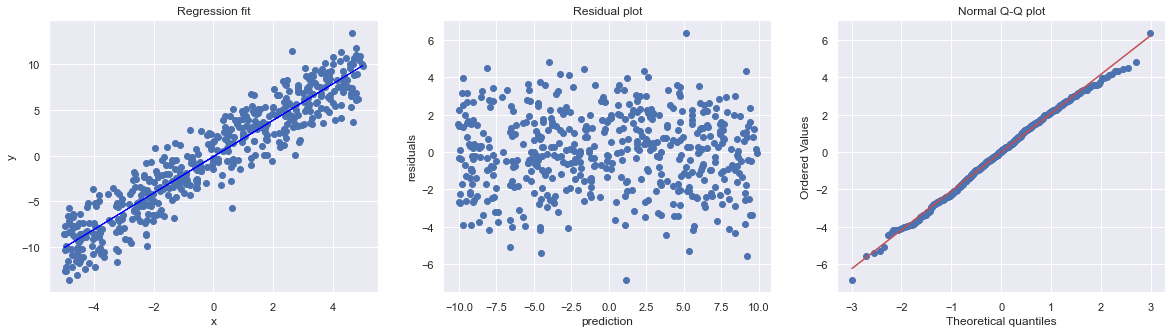

In [34]:
epsilon = 2*np.random.randn(s)
beta = 2
y1 = beta*x + epsilon

diagnostic_plot(x.reshape(s,1), y1) # we reshape x to turn it into a tall column

### Assumption 2: residuals ( ${e_i} = Y_i-\hat{Y}_i$ ) should be normally distributed with zero mean

In [35]:
lr = LinearRegression()
fit = lr.fit(X5,y) # for later use

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


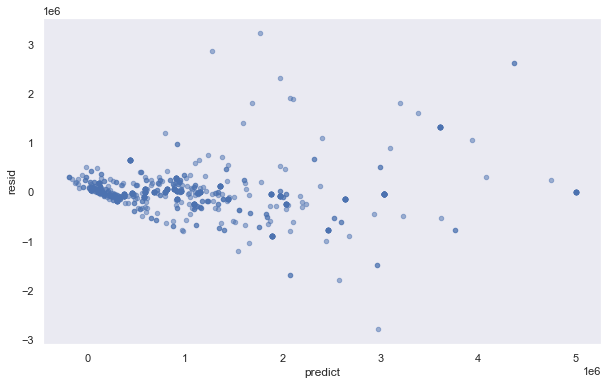

In [36]:
# Plot your predicted values on the x-axis, and your residuals on the y-axis

dfe['predict']=fit.predict(X5)
dfe['resid']=dfe.PRICE-dfe.predict # "residuals"
with sns.axes_style('dark'):
    plot=dfe.plot(kind='scatter',
                  x='predict',y='resid',alpha=0.5,figsize=(10,6))

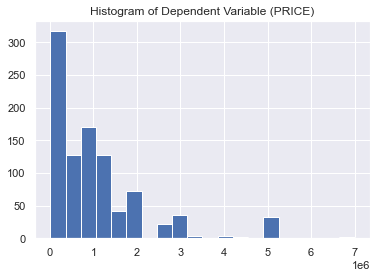

In [37]:
dfe.PRICE.hist(bins=20)
plt.title('Histogram of Dependent Variable (PRICE)');

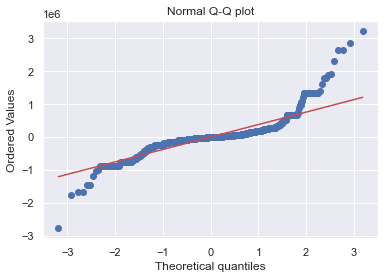

In [38]:
# diagnose/inspect residual normality using qqplot:
stats.probplot(dfe['resid'], dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

### Assumption 3: error terms must have constant variance

In [42]:
model = sm.OLS(y,X5) # "from stats package"
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  PRICE   R-squared (uncentered):                   0.919
Model:                            OLS   Adj. R-squared (uncentered):              0.916
Method:                 Least Squares   F-statistic:                              254.6
Date:                Sun, 26 Sep 2021   Prob (F-statistic):                        0.00
Time:                        01:14:25   Log-Likelihood:                         -13796.
No. Observations:                 958   AIC:                                  2.767e+04
Df Residuals:                     917   BIC:                                  2.787e+04
Df Model:                          41                                                  
Covariance Type:            nonrobust                                                  
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
BED                    -3.258e+05   1.03e+05     -3.153      0.002   -5.29e+05   -1.23e+05
BATH                    5.671e+04   1.04e+05      0.547      0.585   -1.47e+05     2.6e+05
SIZE                    3100.7700    108.800     28.500      0.000    2887.243    3314.297
DISTRICT_أحد            1.975e+05   1.72e+05      1.149      0.251    -1.4e+05    5.35e+05
DISTRICT_اخرى           7.519e+05   1.27e+05      5.926      0.000    5.03e+05       1e+06
DISTRICT_الاندلس        3.676e+05   1.62e+05      2.270      0.023    4.97e+04    6.85e+05
DISTRICT_البديعة       -2.577e+04   1.39e+05     -0.186      0.853   -2.98e+05    2.47e+05
DISTRICT_الجرادية       1.278e+05   1.72e+05      0.743      0.457    -2.1e+05    4.65e+05
DISTRICT_الخالدية        2.65e+05   1.47e+05      1.801      0.072   -2.38e+04    5.54e+05
DISTRICT_الخليج         5.719e+05   1.58e+05      3.609      0.000    2.61e+05    8.83e+05
DISTRICT_الدار البيضاء -6.504e+04   1.49e+05     -0.436      0.663   -3.58e+05    2.28e+05
DISTRICT_الديرة         4.416e+06   1.83e+05     24.193      0.000    4.06e+06    4.77e+06
DISTRICT_الرمال         1.288e+06    1.5e+05      8.586      0.000    9.94e+05    1.58e+06
DISTRICT_السعادة        3.706e+05   1.46e+05      2.547      0.011     8.5e+04    6.56e+05
DISTRICT_السويدي        1.411e+05   2.07e+05      0.683      0.495   -2.64e+05    5.47e+05
DISTRICT_الشرق          3.136e+05      2e+05      1.566      0.118   -7.95e+04    7.07e+05
DISTRICT_الشميسي        1.496e+05    1.7e+05      0.878      0.380   -1.85e+05    4.84e+05
DISTRICT_الصالحية        9.52e+04   1.46e+05      0.654      0.513    -1.9e+05    3.81e+05
DISTRICT_العريجاء        1.04e+05   1.58e+05      0.660      0.510   -2.05e+05    4.13e+05
DISTRICT_العزيزية      -2.276e+05   1.55e+05     -1.471      0.142   -5.31e+05     7.6e+04
DISTRICT_العيينة        3.404e+05   1.73e+05      1.968      0.049     977.202     6.8e+05
DISTRICT_الفوطة          8.46e+04   1.42e+05      0.596      0.551   -1.94e+05    3.63e+05
DISTRICT_الفيحاء       -2.612e+05   1.67e+05     -1.562      0.119   -5.89e+05     6.7e+04
DISTRICT_المرقب         2.747e+04   1.94e+05      0.142      0.887   -3.52e+05    4.07e+05
DISTRICT_المروة         1.044e+06    1.8e+05      5.811      0.000    6.92e+05     1.4e+06
DISTRICT_الملز          2.798e+05   1.62e+05      1.725      0.085   -3.86e+04    5.98e+05
DISTRICT_الندوة         2.921e+05    1.5e+05      1.954      0.051   -1346.966    5.85e+05
DISTRICT_النسيم الغربي  5.002e+04   1.42e+05      0.352      0.725   -2.29e+05    3.29e+05
DISTRICT_النظيم           3.4e+05   1.76e+05      1.936      0.053   -4602.356    6.85e+05
DISTRICT_اليمامة        4.676e+04   1.49e+05      0.313      0.754   -2.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


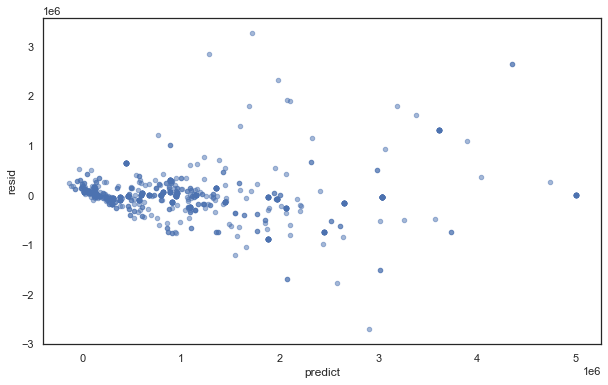

In [45]:
# create residual plot
dfe['predict']=fit.predict(X5) # "we added the predication to the data frame"
dfe['resid']= y-dfe.predict # "we added the residuals to the data frame"
with sns.axes_style('white'):
    plot = dfe.plot(
        kind='scatter', x='predict', y='resid', alpha=0.5, figsize=(10,6))

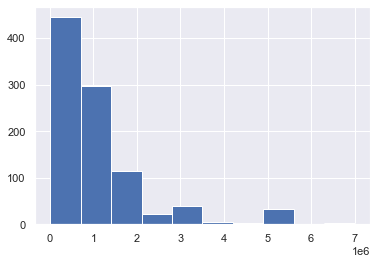

In [46]:
# create histogram
dfe.PRICE.hist();

# note the Right skew

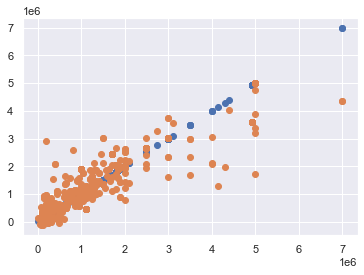

In [54]:
# quick reg plot
plt.scatter(dfe.PRICE,y)
plt.scatter(dfe.PRICE,dfe.predict);

> The predictions are in orange, and they're not able to capture the exponential explosions of some movie profits.

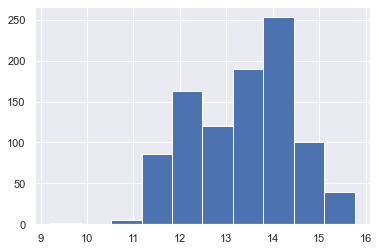

In [48]:
np.log(dfe.PRICE).hist();

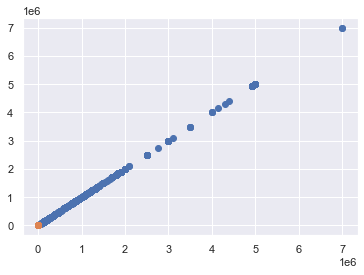

In [55]:
plt.scatter(dfe.PRICE,y)
plt.scatter(np.log(dfe.PRICE),np.log(dfe.predict));

> From here we can see after compress the raw data we can see that helps us model more accurately.

## Save model 

In [56]:
filename = 'final_ Aqar_model.sav'
pickle.dump(lr, open(filename, 'wb'))

## Conclusion 

we have accomplished a good results with the linear regrission model and at start we have using a web scraping to keep the data updated and real data. from that we devlop two models linear and ridge. all of those model has a very good results as a start 

## Future work
This is a simple use for our model since we only took Riyadh real estate data and only from Aqar for future we want to train and test our model on many cites and other sources of data.

